Evaluating DAN model for FER task:

https://github.com/yaoing/dan

Eval Dataset:

https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition


In [1]:
import numpy as np
import pandas as pd

import os
import cv2

from PIL import Image

import torch
from torchvision import transforms, models
from torch import nn
from torch.nn import functional as F
import torch.nn.init as init

from sklearn.metrics import accuracy_score



In [2]:
class DAN(nn.Module):
    def __init__(self, num_class=7,num_head=4, pretrained=True):
        super(DAN, self).__init__()
        
        resnet = models.resnet18(pretrained)
        
        if pretrained:
            checkpoint = torch.load('./models/resnet18_msceleb.pth')
            resnet.load_state_dict(checkpoint['state_dict'],strict=True)

        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.num_head = num_head
        for i in range(num_head):
            setattr(self,"cat_head%d" %i, CrossAttentionHead())
        self.sig = nn.Sigmoid()
        self.fc = nn.Linear(512, num_class)
        self.bn = nn.BatchNorm1d(num_class)


    def forward(self, x):
        x = self.features(x)
        heads = []
        for i in range(self.num_head):
            heads.append(getattr(self,"cat_head%d" %i)(x))
        
        heads = torch.stack(heads).permute([1,0,2])
        if heads.size(1)>1:
            heads = F.log_softmax(heads,dim=1)
            
        out = self.fc(heads.sum(dim=1))
        out = self.bn(out)
   
        return out, x, heads

class CrossAttentionHead(nn.Module):
    def __init__(self):
        super().__init__()
        self.sa = SpatialAttention()
        self.ca = ChannelAttention()
        self.init_weights()


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                init.constant_(m.weight, 1)
                init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                init.normal_(m.weight, std=0.001)
                if m.bias is not None:
                    init.constant_(m.bias, 0)
    def forward(self, x):
        sa = self.sa(x)
        ca = self.ca(sa)

        return ca


class SpatialAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1x1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
        )
        self.conv_3x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3,padding=1),
            nn.BatchNorm2d(512),
        )
        self.conv_1x3 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(1,3),padding=(0,1)),
            nn.BatchNorm2d(512),
        )
        self.conv_3x1 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=(3,1),padding=(1,0)),
            nn.BatchNorm2d(512),
        )
        self.relu = nn.ReLU()


    def forward(self, x):
        y = self.conv1x1(x)
        y = self.relu(self.conv_3x3(y) + self.conv_1x3(y) + self.conv_3x1(y))
        y = y.sum(dim=1,keepdim=True) 
        out = x*y
        
        return out 

class ChannelAttention(nn.Module):

    def __init__(self):
        super().__init__()
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.attention = nn.Sequential(
            nn.Linear(512, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 512),
            nn.Sigmoid()    
        )


    def forward(self, sa):
        sa = self.gap(sa)
        sa = sa.view(sa.size(0),-1)
        y = self.attention(sa)
        out = sa * y
        
        return out

In [3]:
data_transforms = transforms.Compose([
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])
                                ])

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
emotions = ['neutral', 'happy', 'sad', 'surprised', 'fear', 'disgust', 'anger']

In [5]:
emotion_model = DAN(num_head=4, num_class=7, pretrained=False)
emotion_model.to(device)
checkpoint = torch.load('../checkpoints/affecnet7_epoch6_acc0.6569.pth', map_location=device)
emotion_model.load_state_dict(checkpoint['model_state_dict'], strict=True)
emotion_model.eval()

c:\Users\ashsy\OneDrive\Desktop\Git repositories\RT-Face-Emotion-Detection\.venv\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
c:\Users\ashsy\OneDrive\Desktop\Git repositories\RT-Face-Emotion-Detection\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\ashsy\AppData\Local\Temp\ipykernel_13060\3678287634.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch

DAN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [6]:
dataset_path = '../datasets/images/'

In [7]:
# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

face_cascade = cv2.CascadeClassifier('../src/haarcascade_frontalface_default.xml')

# Loop through each folder (each folder represents an id)
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        # Loop through each image in the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            # Load the image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)

            # If no faces are detected, skip this image
            if len(faces) == 0:
                print(f"No face detected in {img_path}, skipping")
                continue

            # extract the first face
            (x, y, w, h) = faces[0]
            # get roi
            roi = img[y:y + h, x:x + w]
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            roi = Image.fromarray(roi)

            # preprocess according to paper
            roi_trf = data_transforms(roi).to(device)
            roi_trf = roi_trf.view(1, 3, 224, 224)

            with torch.no_grad():
                out, _, _ = emotion_model(roi_trf)
                _, pred = torch.max(out, 1)
                predicted_emotion = emotions[int(pred)]

            true_labels.append(img_name.split('.')[0].lower())  # Assuming the image name is the true label
            predictions.append(predicted_emotion)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

No face detected in ../datasets/images/10\Surprised.jpg, skipping
No face detected in ../datasets/images/8\Happy.jpg, skipping
No face detected in ../datasets/images/8\Sad.jpg, skipping
No face detected in ../datasets/images/8\Surprised.jpg, skipping
Accuracy: 60.47%


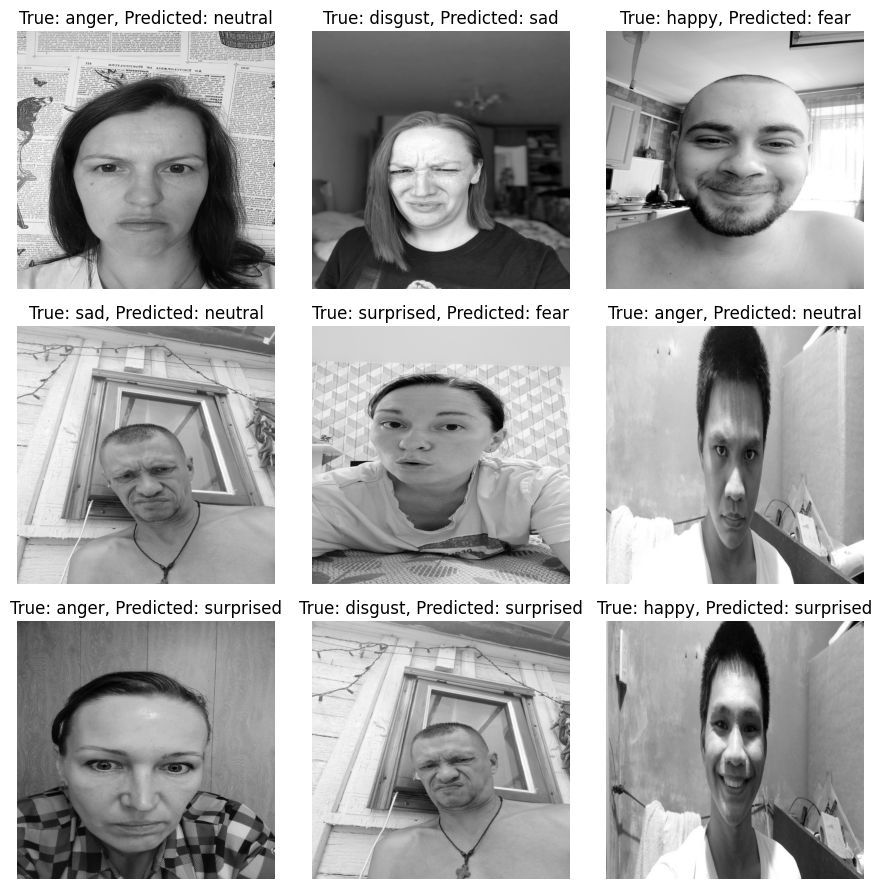

In [8]:
import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

# Plot up to 10 incorrect predictions
num_images = min(9, len(incorrect_indices))

plt.figure(figsize=(9, 9))
for i in range(num_images):
    index = incorrect_indices[i]
    img_path = os.path.join(dataset_path, str(index % 10), f'{true_labels[index].capitalize()}.jpg') # Construct the image path
    try:
        img = Image.open(img_path).convert('L')  # Open image and convert to grayscale (luminance)
        img = img.resize((480, 480))  # Resize the image
        img_array = np.array(img)  # Convert to numpy array
    except FileNotFoundError:
        print(f"Image not found: {img_path}")
        continue

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"True: {true_labels[index]}, Predicted: {predictions[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

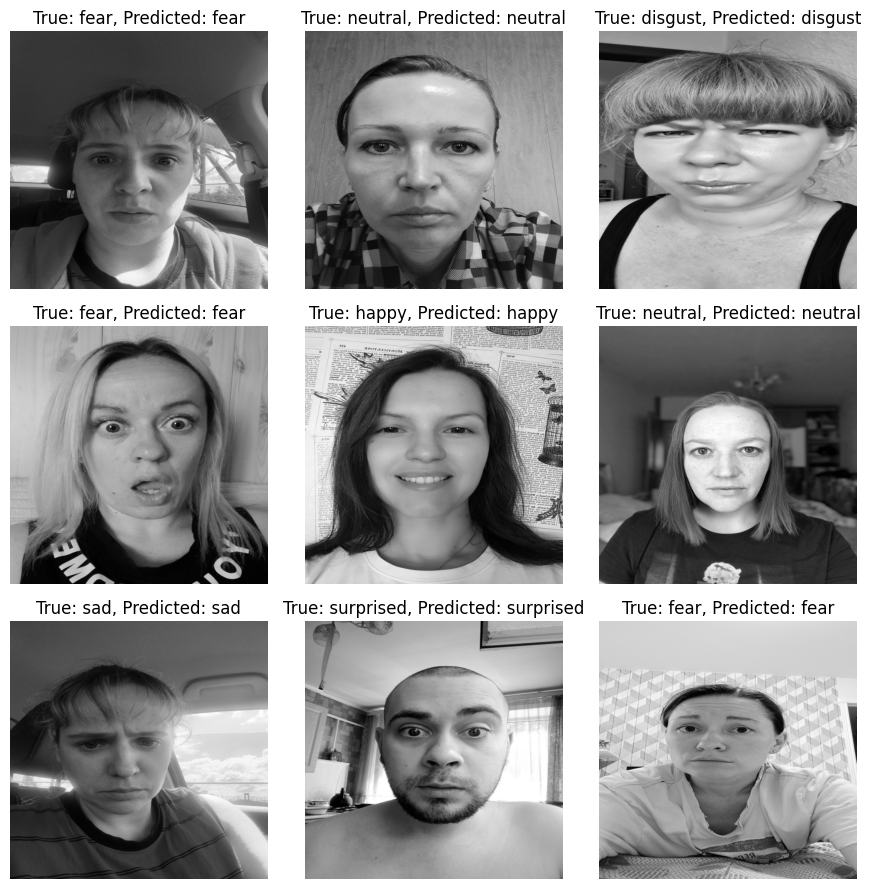

In [9]:
import matplotlib.pyplot as plt

# Find indices where the predictions were correct
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == predictions[i]]

# Plot up to 10 incorrect predictions
num_images = min(9, len(correct_indices))

plt.figure(figsize=(9, 9))
for i in range(num_images):
    index = correct_indices[i]
    img_path = os.path.join(dataset_path, str(index % 10), f'{true_labels[index].capitalize()}.jpg') # Construct the image path
    try:
        img = Image.open(img_path).convert('L') 
        img = img.resize((480, 480))  
        img_array = np.array(img)  
    except FileNotFoundError:
        print(f"Image not found: {img_path}")
        continue

    plt.subplot(3, 3, i + 1)
    plt.imshow(img_array, cmap='gray')
    plt.title(f"True: {true_labels[index]}, Predicted: {predictions[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.60      0.32      0.41        19
       happy       0.64      0.47      0.55        19
         sad       0.55      0.63      0.59        19
   surprised       0.93      0.72      0.81        18
        fear       0.53      0.84      0.65        19
     disgust       0.65      0.61      0.63        18
       anger       0.50      0.65      0.56        17

    accuracy                           0.60       129
   macro avg       0.63      0.61      0.60       129
weighted avg       0.63      0.60      0.60       129

